In [73]:
# Necessary libraries loaded to load datasets, wrangle data, and perform some summarization and visualization
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

View and load the datasets: both appear to have a delimiter of "," so will use read_csv

In [74]:
players_data <- read_csv("data/players.csv")
sessions_data <- read_csv("data/sessions.csv")

players_data
sessions_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


I can compute the mean values of quantitative data in the players dataset. 

In [75]:
mean_quantative <- summarize(players_data, 
                             mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2),
                             mean_age = round(mean(Age, na.rm = TRUE), 2))
                   
mean_quantative

mean_played_hours,mean_age
<dbl>,<dbl>
5.85,21.14


(1) The two datasets, players.csv and sessions.csv, consist of information from survey results. The data could be inaccurate since it is based on survey results and self-ratings. There is also a lot of missing data. 

players.csv contains player demographics, information, and engagement and has 196 observations and 7 variables. The mean age of players is 21.14 years and the mean played hours 5.85 hours.
| Variable Name | Data Type | Meaning |  Issues  |
|:--------:|:--------:|:--------:|:--------:|
|  experience   |  Character   |  Player’s self-reported skill level   |  Users rate their skill: bias may be present |
|  subscribe    |  Logical   |  Player's subscription status   |  N/A  |
|  hashedEmail  |  Character   |  Encripted player email   |  N/A  |
|played_hours|Double|Total hours spent playing on server | Few players contribute to total playtime |
|name|Character|Player's name| N/A|
|gender|Character| Player's gender| Missing data |
|Age|Double|Player's age| Missing data |

sessions.csv contains information on individual play sessions for each player; each row represents one session's player and duration of play. It has 1535 observations and 5 variables:
| Variable Name | Data Type | Meaning |  Issues  |
|:--------:|:--------:|:--------:|:--------:|
|  hashedEmail  |  Character   |  Email linking session to player  |  N/A  |
|  start_time   |  Character   |  Session start time  |  N/A |
|  end_time    |  Character   |  Session end time |  Missing data  |
|  original_start_time | Double | Beginning of session timestamp | N/A|
|  original_end_time | Double | Ending of session timestamp| Missing data |

(2) My predictive question is based on the broader question to determine what "kinds" of players are most likely to contribute a large amount of data. The question is: "Does age negatively affect the overall number of hours played?" To address this, I will use players.csv, specifically the variables, Age and played_hours. Before creating the visualization, I will remove invalid or missing values from both variables.

In [76]:
players_data <- players_data |>
  filter(played_hours > 0) |>
  filter(!is.na(Age))
players_data

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,TRUE,ba24bebe588a34ac546f8559850c65bc90cd9d51b821581bd6e25cff437a1081,0.1,Gabriela,Female,44
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


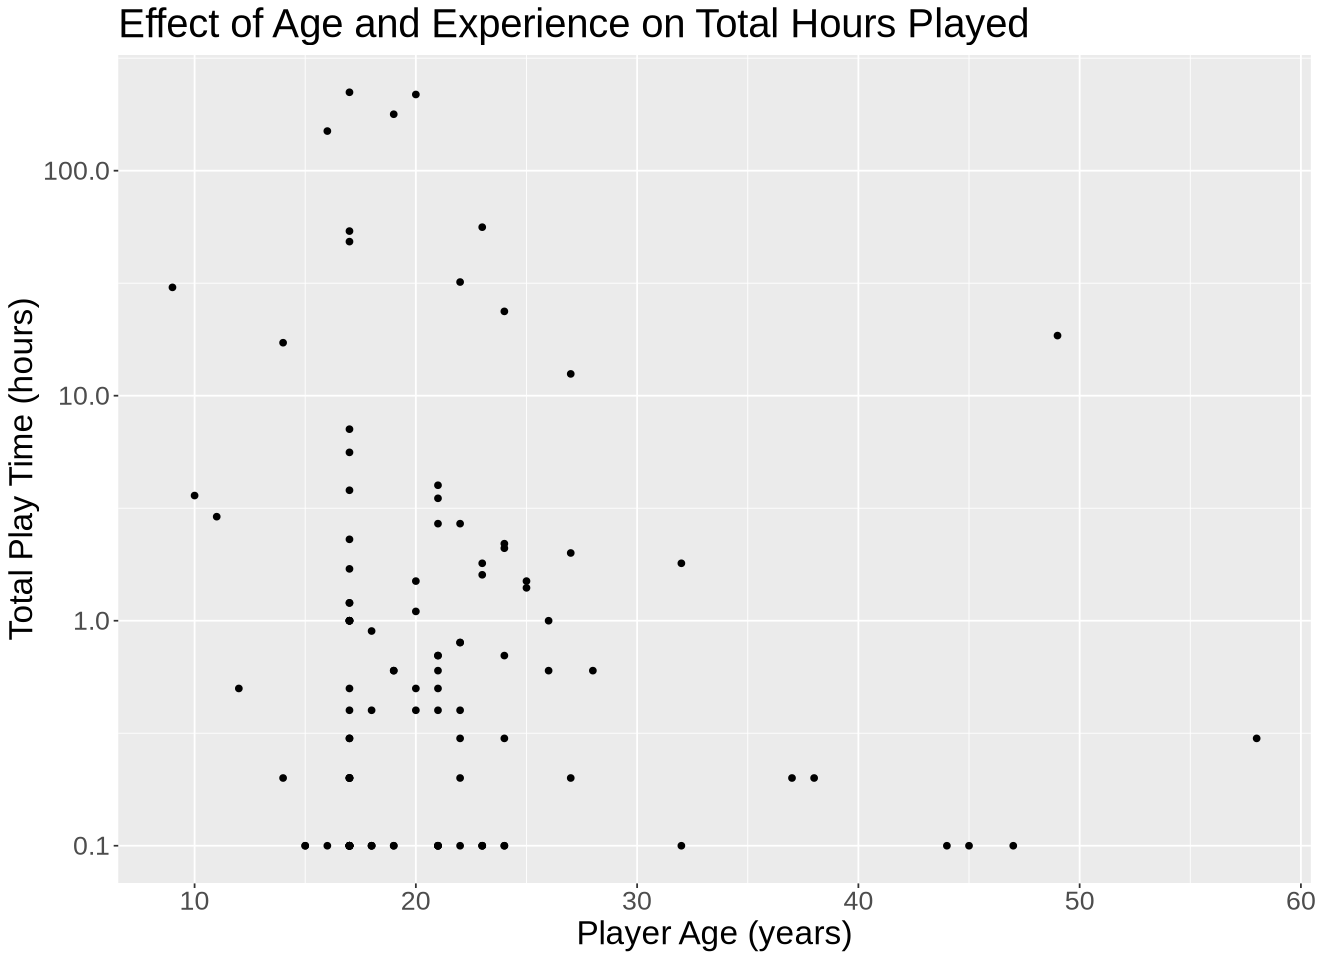

In [77]:
options(repr.plot.width = 11, repr.plot.height = 8)

age_experience_effect <- players_data |>
  ggplot(aes(x = Age, y = played_hours)) +
         geom_point() +
         labs(x = "Player Age (years)",
              y = "Total Play Time (hours)",
              title = "Effect of Age and Experience on Total Hours Played") +
         scale_y_log10(labels = comma) +
         scale_color_brewer(palette = "Set2") +
         theme(text = element_text(size = 20))
age_experience_effect



(3) This plot shows the relationship between player age and total hours played. There appears to be a negative weak relationship between age and total hours played; younger players tend to spend more time than older players. Most players are under the age of 30. Although there is a downward trend, the points are quite spread out. The trend is approximately linear. 

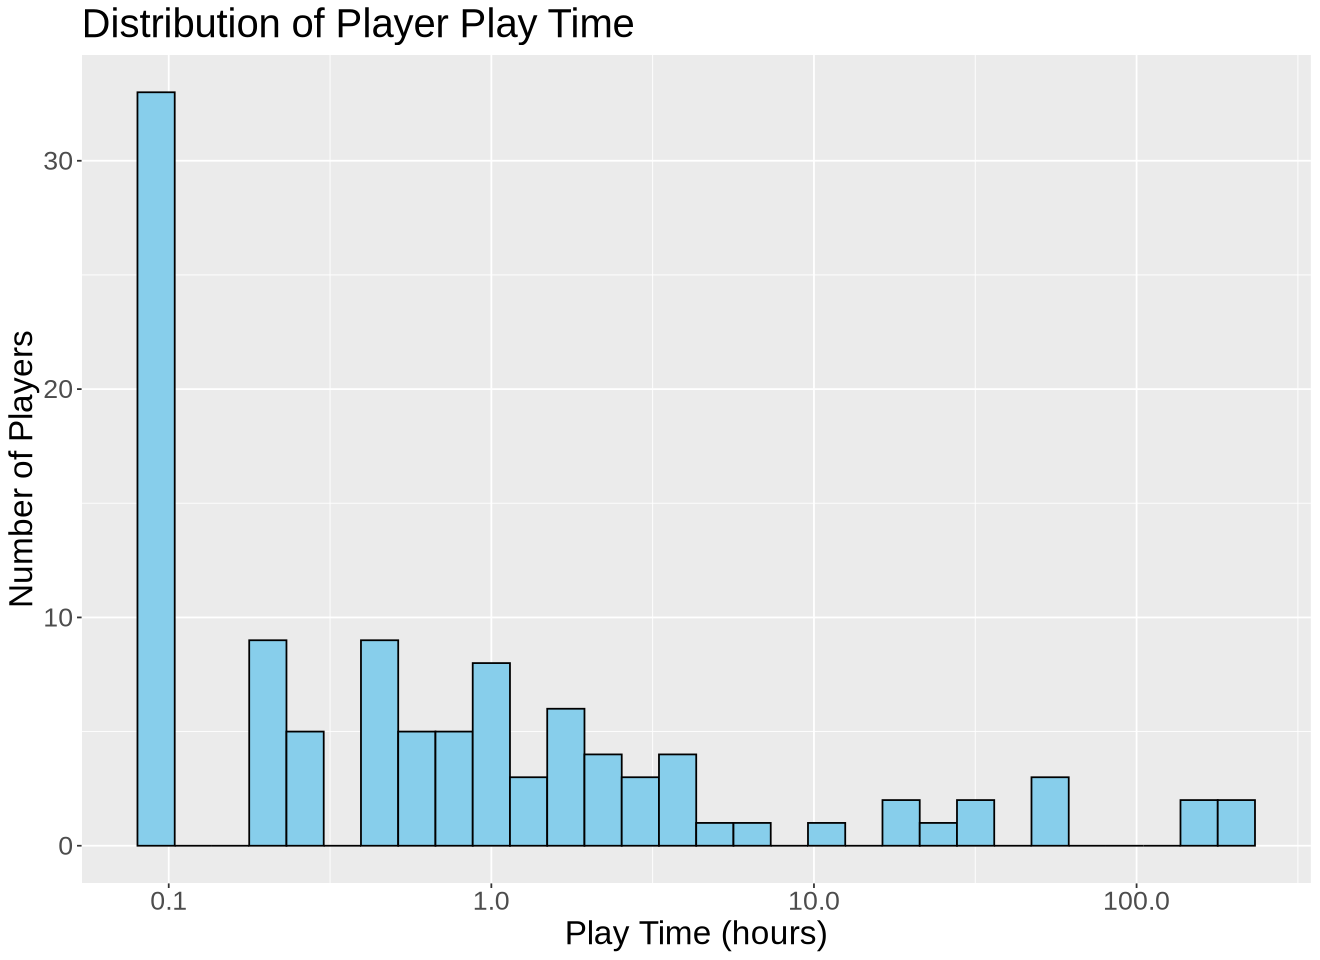

In [78]:
player_playtime_distrib <- players_data |> 
  ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 30, fill = "skyblue", color = "black") +
    scale_x_log10() +
    labs(title = "Distribution of Player Play Time",
         x = "Play Time (hours)",
         y = "Number of Players") +
    theme(text = element_text(size = 20))
player_playtime_distrib

(3) Most players spend very few time on the game and the number of players with high playtimes is small. This means a few “super-players” dominate, making any averages misleading.

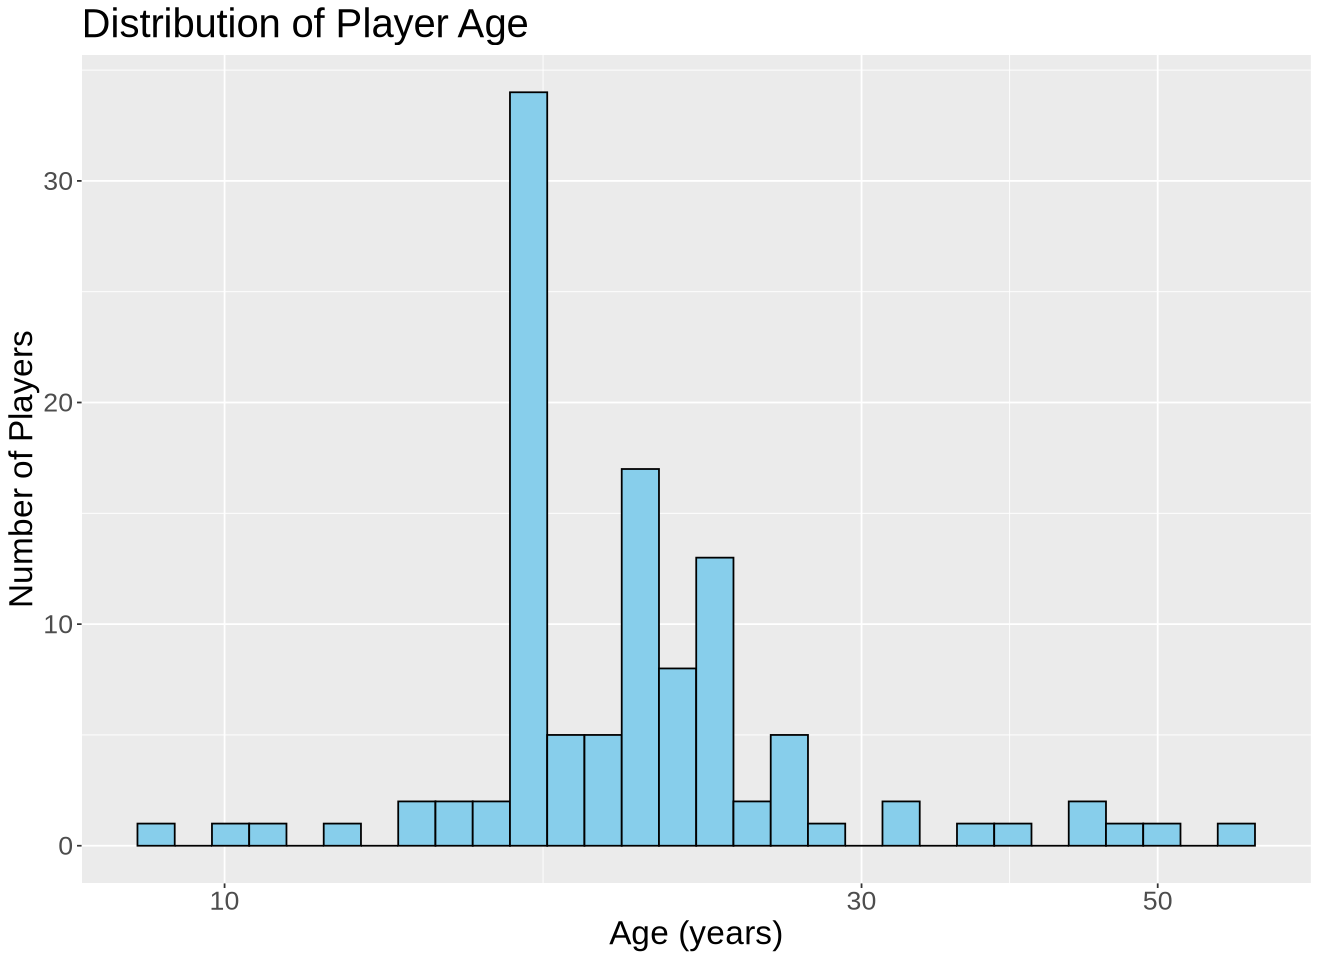

In [79]:
player_age_distrib <- players_data |> 
  ggplot(aes(x = Age)) +
    geom_histogram(bins = 30, fill = "skyblue", color = "black") +
    scale_x_log10() +
    labs(title = "Distribution of Player Age",
         x = "Age (years)",
         y = "Number of Players") +
    theme(text = element_text(size = 20))
player_age_distrib

(3) The distribution is concentrated between younger ages. Outside this range, ages only appear a few times, which is the case for older players. This supports the idea that younger people have more data, players, and as a result, more playtime.

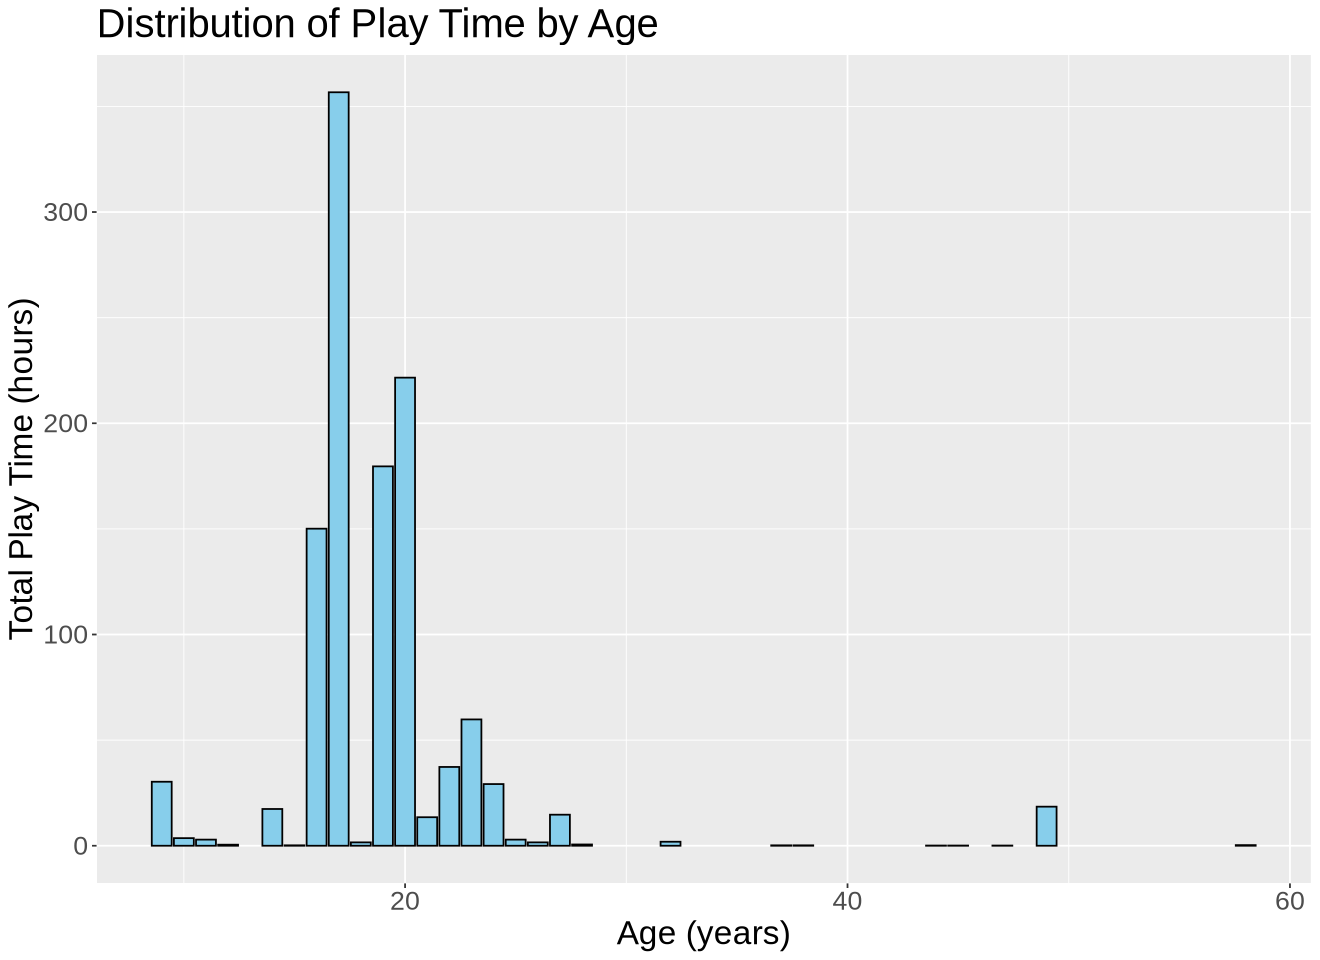

In [80]:
playtime_age_distrib <- players_data |>
  ggplot(aes(x = Age, y = played_hours)) +
    geom_bar(stat = "summary", fun = "sum",, fill = "skyblue", color = "black") +
    labs(title = "Distribution of Play Time by Age",
        x = "Age (years)",
        y = "Total Play Time (hours)") +
    theme(text = element_text(size = 20))

playtime_age_distrib

Most of the total hours come from younger players. Players over 30 contribute very little total playtime. This supports the trend that age is negatively related to total hours played.

(4) To address my question, I will use a bar graph visualization. I will compare total playtime across ages and identify any trends. This method is appropriate because the question is exploratory. The bar graph accumulates values of total playtime so patterns are easy to spot. This is also effective because the data contains many same-age observations. It requires assumptions that that playtime is completely accurate. However, this graph has limitations. There are far many more younger players that the trend may not be accurate. The graph itself not account for other factors or individual variation (a single user's high playtime could result in a high total playtime). Since the method is exploratory and predictive, the most important factor is to select the best summary method. I will clean the data before creating my visualization by removing rows with missing data. 

(5) Github Repository link: https://github.com/elisdale/videogame_ds_project